# 0. 导入需要的包


In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time 
import os
import copy
import torch.utils.data

plt.ion()

# 1. 导入数据

## 使用torchvision和torch.utils.data


In [6]:
# Data segmentation and normalization for training
# just normalization for validation

data_transforms ={
    'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]),
    'val': transforms.Compose([transforms.Resize(256),
                              transforms.CenterCrop(224),
                              transforms.ToTensor(),
                              transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]),
    
}

data_dir = 'D:\\hymenoptera_data\\'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),
                                         data_transforms[x])
                 for x in ['train','val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 4, 
                                             shuffle= True, num_workers =0)
              for x in ['train','val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']
                }

class_names = image_datasets['train'].classes

device = torch.device("cpu")

print(dataset_sizes)

{'train': 244, 'val': 153}


# 2. 可视化一些图片

matplotlib.pyplot.imshow() : H,W,C 0-1 
pytorch tensor : C,H,W  0-1 

* 因此需要使用numpy.transpose((1,2,0)) 来将z与x互换
* 同时做逆变换:
    1. ( 正变换：  256image -> totensor() -> normalize(...) )
    2. ( 逆变换：  0-1 normalized tensor -> 0-1 tensor )
    
## make_grid()

* 把 tensor (Batchsize x C x H x W) 转成 一张图片


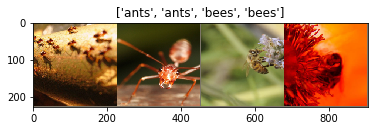

In [13]:
def imshow(inp, title = None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    inp = std * inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# get a batch of training data:
inputs, classes = next(iter(dataloaders['train']))

# make a grid from batch

out = torchvision.utils.make_grid(inputs)

imshow(out, title = [class_names[x] for x in classes])

# 3. 训练模型

* scheduling the learning rate
* saving the best model

lr scheduler : object from torch.optim.lr_scheduler

In [26]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs -1 ))
        print('-' * 10)
        
        # each  epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                model.train()
            else:
                model.eval() # evaluate mode
            running_loss = 0.0
            running_corrects = 0
            
            # itertate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs,1)
                    loss = criterion(outputs, labels)
                    
                    # backword + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'val' and epoch_acc > best_acc :
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [27]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [28]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [29]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5451 Acc: 0.7295
val Loss: 0.4515 Acc: 0.8497

Epoch 1/24
----------
train Loss: 0.4920 Acc: 0.7869
val Loss: 0.2499 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.4758 Acc: 0.8074
val Loss: 0.2528 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.3922 Acc: 0.8443
val Loss: 0.2741 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.4403 Acc: 0.8402
val Loss: 0.2343 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.5547 Acc: 0.7787
val Loss: 0.2391 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.5915 Acc: 0.7992
val Loss: 0.3578 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3715 Acc: 0.8689
val Loss: 0.2747 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.2721 Acc: 0.8934
val Loss: 0.3255 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.4316 Acc: 0.8361
val Loss: 0.2632 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.3342 Acc: 0.8607
val Loss: 0.2247 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.2901 Acc: 0.8852
val Loss: 0.2139 Acc: 0.9281

Ep

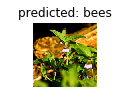

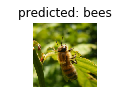

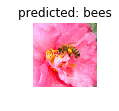

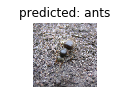

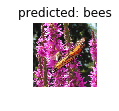

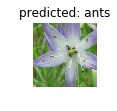

In [31]:
visualize_model(model_ft)


# 4. 卷积层当作固定的特征提取器

freeze all the network except the final layer.
set requires_grad == False to freeze the parameter so that the gradients are not computed in backward()


In [32]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [33]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=12)

Epoch 0/11
----------
train Loss: 0.6504 Acc: 0.6148
val Loss: 0.3082 Acc: 0.8889

Epoch 1/11
----------
train Loss: 0.4502 Acc: 0.7787
val Loss: 0.1810 Acc: 0.9281

Epoch 2/11
----------
train Loss: 0.4045 Acc: 0.8238
val Loss: 0.1713 Acc: 0.9346

Epoch 3/11
----------
train Loss: 0.5622 Acc: 0.7582
val Loss: 0.5450 Acc: 0.8170

Epoch 4/11
----------
train Loss: 0.6166 Acc: 0.7746
val Loss: 0.1676 Acc: 0.9477

Epoch 5/11
----------
train Loss: 0.4710 Acc: 0.8197
val Loss: 0.2222 Acc: 0.9216

Epoch 6/11
----------
train Loss: 0.4218 Acc: 0.8197
val Loss: 0.3158 Acc: 0.8824

Epoch 7/11
----------
train Loss: 0.3669 Acc: 0.8279
val Loss: 0.1727 Acc: 0.9477

Epoch 8/11
----------
train Loss: 0.4039 Acc: 0.8238
val Loss: 0.1801 Acc: 0.9412

Epoch 9/11
----------
train Loss: 0.3159 Acc: 0.8730
val Loss: 0.1657 Acc: 0.9412

Epoch 10/11
----------
train Loss: 0.2628 Acc: 0.8852
val Loss: 0.2136 Acc: 0.9346

Epoch 11/11
----------
train Loss: 0.3657 Acc: 0.8238
val Loss: 0.1673 Acc: 0.9477

Tr

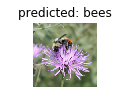

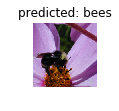

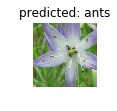

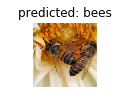

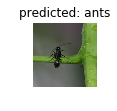

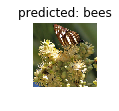

In [34]:
visualize_model(model_conv)

plt.ioff()
plt.show()